In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statsmodels.api as sm
from scipy import stats
import scipy as sc
import seaborn as sns

En este notebook se plantea un analísis exploratorio de datos con respecto a ciertas caracteristicas de las llamaradas solares, las cuales son duración, posición en x, posición en y las cuales mostrarón tener cierta afinidad con las distribuciónes chi cuadrada en el caso de la duración y la distribucion normal en el caso de las posicion x,y. Sin embargo al realizar los ajustes se tienen densidades de probabilidad con valores muy bajos, ademas de que muchas pruebas de hipotesis realizadas con respecto a la duración no se ajustan a los datos. Esto se debe a que se tienen algunas relaciones que a pesar de no seguir una ley de potencias si tienen relaciones causales (en el caso de los rangos de emisiones de rayos X de bajas y altas energias). Sin embargo con la prueba F de fisher se pueden tener valores interpretables con respecto a la hipotesis nula que las varianzas tienen una proporcion 1 osea $$\frac{\sigma_{1}}{\sigma_{2}}=1$$
A continuación se comienza realizando un ajuste al formato de la fecha de todos los eventos, con un DateTime

In [102]:
'''
se define el indice Datetime para eliminar las columnas referentes a las fechas
de las erupciones y su hora de inicio. ademas se calculan las energias pasando 
los valores de la columna energy.KeV a dos valores float.
'''
file_path = r"C:\Python\HessiSolarFlare2018.csv"  #2002to2018.csv
df = pd.read_csv(file_path)
formatT = '%Y-%m-%d %H:%M:%S'
df['Datetime'] = pd.to_datetime(df['start.date'] + ' ' + df['start.time'], format=formatT)
df = df.set_index(pd.DatetimeIndex(df['Datetime']))
df = df.drop(columns=['start.date', 'start.time', 'Datetime'])
Emin = []
Emax = []
Eprom = []
for i in df['energy.kev']:
    result = re.findall(r'[\d\.\d]+', i)
    Emax.append(float(result[1]))
    Emin.append(float(result[0]))
    Eprom.append((float(result[0]) + float(result[1]))/2)
df['EnergiaMin']=Emin
df['EnergiaMax']=Emax
df['EnergiaProm']=Eprom

'''funcion filtro recibe un dataframe una columna del mismo (un string),
y una condición, retorna un dataframe filtrado por el condicional 
''' 
def Filtro(df,col,cond):
    a=df[col] == cond
    dfa=df[a]
    return dfa  

def filtrof(data, Lbanderas): # Filtro por bandera
    for bandera in Lbanderas: 
        ## filter
        data = data[data['flag.1'] != bandera]
        
        data = data[data['flag.2'] != bandera]

        data = data[data['flag.3'] != bandera]
        
        data = data[data['flag.4'] != bandera]

        values = data['flag.5'].values
        lfilter = [i for i in list(values[pd.notnull(values)]) if bandera in i]
        data = data[~data['flag.5'].isin(lfilter)]
            
    return data
df=df[df['radial'] < 4000]
df=df[df['energy.kev']!='3-6']
df=df[df['active.region.ar']<2700]
df['logdur']=np.log(df['duration.s'])
#print(dffiltro.value_counts('flag.2'))

en la siguiente celda se filtran las banderas para un analisis 'filtrado' que se hará en futuras celdas, ademas se hacen dataframes sin filtrar en los rangos de energia 6-12, 12-25, 25-50, 50-100 para el analisis de la variable duration.s, también se realiza un boxplot de la duracion con respecto a las energias), se puede observar que todas tienen medias distintas ademas de una cantidad seria de outliers, y uno podria tratar de eliminar los outliers pero se estaria perdiendo algo muy interesante con respecto a la varianza de estos resultados cuyas proporciones se prueban más adelante

Text(0.5, 1.0, 'Boxplot')

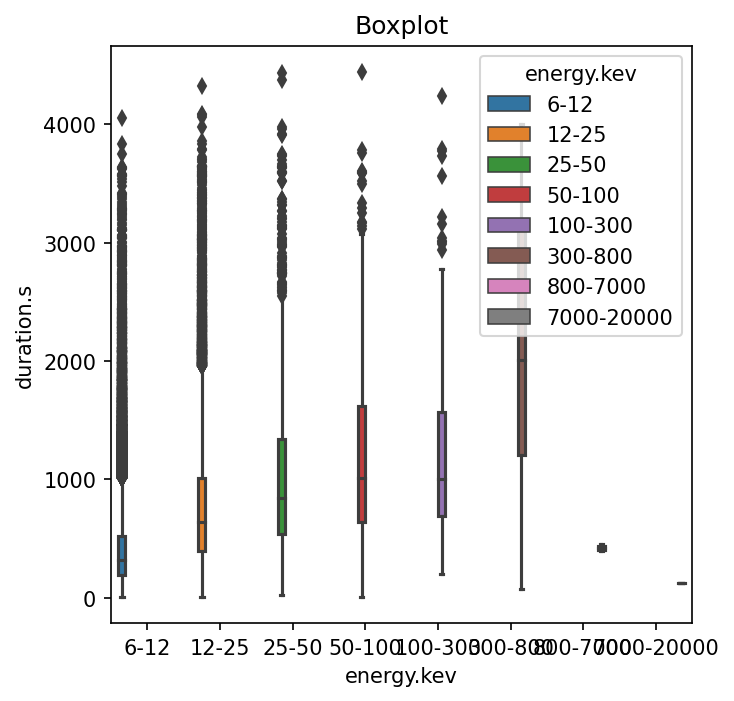

In [103]:
df['duration.ls']=np.log(df['duration.s'])
lista=['NS','PE','P0']
dffiltro=filtrof(df,lista)
#df['energy.kev'].value_counts()
energy1 = Filtro(df,'energy.kev','6-12') # Se filtra por rango de energias
energy2 = Filtro(df,'energy.kev','12-25')
energy3 = Filtro(df,'energy.kev','25-50')
energy4 = Filtro(df,'energy.kev','50-100')
#dfe=pd.concat([energy1,energy2,energy3]).sort_values('Datetime')
#dfdt = dfe['duration.s']
#dfep = dfe['EnergiaProm']
#datos4 = energy4['duration.s']
'''diagrama de caja y bigote para la duracion 
de las eripciones con respecto a los rangos de energia'''
plt.figure(figsize=(5,5), dpi = 150)
sns.boxplot(data=df.sort_values('EnergiaProm'),x='energy.kev',y='duration.s',hue='energy.kev')
plt.title('Boxplot')

$$
 \textbf{grafica de la posición de las erupciones clasificada por sus energias}
$$

C:\Users\Juan Jimenez\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


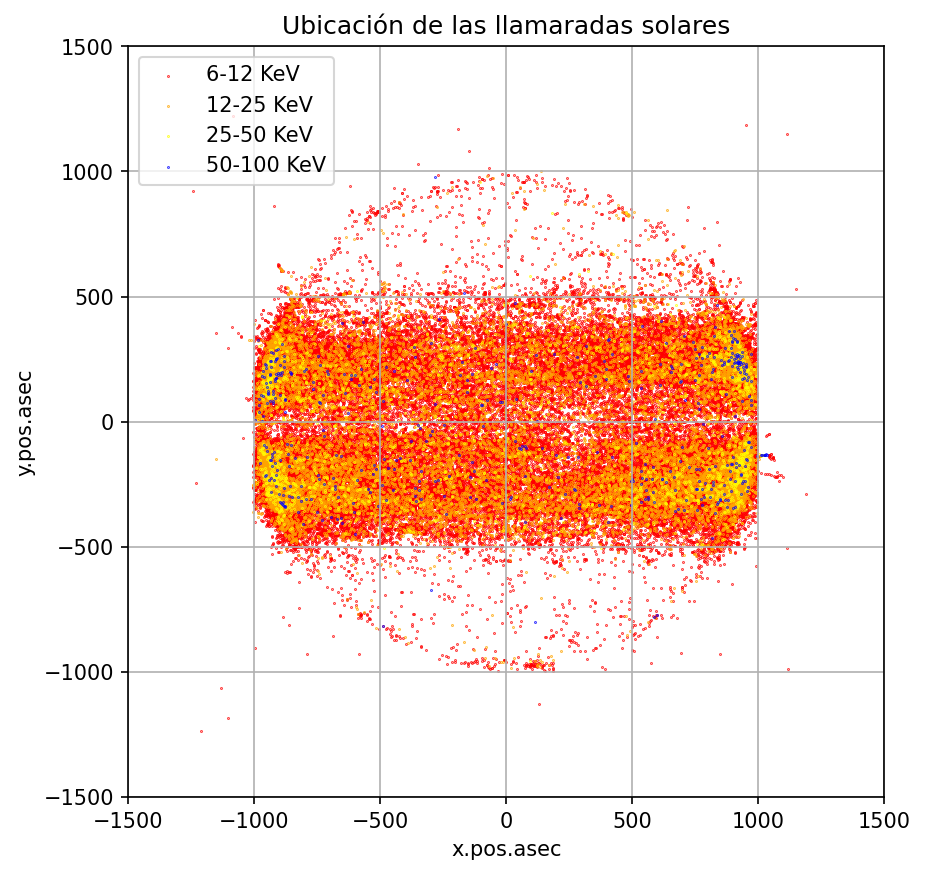

In [104]:
'''
scatter de las posiciones x.pos.asec y y.pos.asec
de cada rango de energias mayores al rango 3-6 kev
probablamente mejor con un cmap
'''
plt.figure(figsize=(6.5,6.5), dpi = 150, edgecolor='black')
plt.xlim(-1500,1500)
plt.ylim(-1500,1500)
plt.grid()
plt.title('Ubicación de las llamaradas solares')
plt.ylabel('y.pos.asec')
plt.xlabel('x.pos.asec')
plt.scatter(energy1['x.pos.asec'], energy1['y.pos.asec'],s=0.1, color='red', label='6-12 KeV')
plt.scatter(energy2['x.pos.asec'], energy2['y.pos.asec'],s=0.1, color='orange',label='12-25 KeV')
plt.scatter(energy3['x.pos.asec'], energy3['y.pos.asec'],s=0.1, color='yellow',label='25-50 KeV')
plt.scatter(energy4['x.pos.asec'], energy4['y.pos.asec'],s=0.1, color='blue', label='50-100 KeV')
plt.legend()

$$
\textbf{Matriz de correlación}
$$

<AxesSubplot:title={'center':'Mapa de calor con respecto \n a la correlación de la base de datos'}>

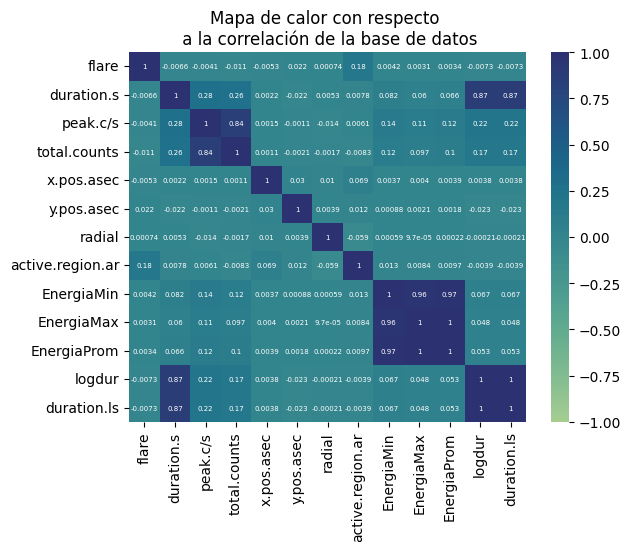

In [105]:
'''se trabaja un mapa de calor para la 
   matriz  de correlación'''

matriz=df.corr(method='pearson',numeric_only=float)
plt.title('Mapa de calor con respecto \n a la correlación de la base de datos')
sns.heatmap(matriz,cmap='crest',annot=True,
           annot_kws={'fontsize':5}
           ,vmin=-1,vmax=1)

<Figure size 640x480 with 0 Axes>

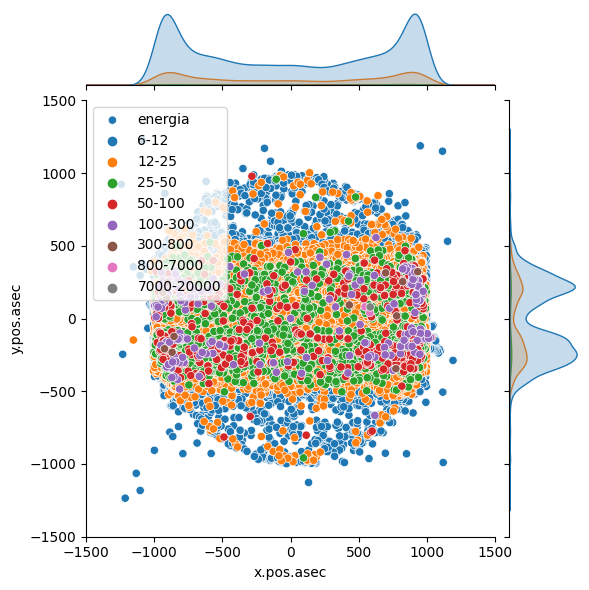

In [106]:
plt.figure()
sns.jointplot(df.sort_values('EnergiaProm'), x='x.pos.asec',y='y.pos.asec',kind='scatter',hue='energy.kev',xlim=(-1500,1500),ylim=(-1500,1500),label='energia')
plt.legend(loc='upper left')

In [107]:
#separacion por emisferios positivos para x,y
dfx=df[df['x.pos.asec'] > 0]
dfx=dfx[dfx['x.pos.asec'] < 1000]
dfy=df[df['y.pos.asec']> 0]
dfy=dfy[dfy['y.pos.asec']< 1000]
#dataframes en la posicion positiva en x (a la derecha del 0)
energypox1 = Filtro(dfx,'energy.kev','6-12')
energypox2 = Filtro(dfx,'energy.kev','12-25')
energypox3 = Filtro(dfx,'energy.kev','25-50')
energypox4 = Filtro(dfx,'energy.kev','25-100')
#dataframes en la posicion positiva de y (arriba de 0)
energypoy1 = Filtro(dfy,'energy.kev','6-12')
energypoy2 = Filtro(dfy,'energy.kev','12-25')
energypoy3 = Filtro(dfy,'energy.kev','25-50')
energypoy4 = Filtro(dfy,'energy.kev','25-100')

In [108]:
#sns.kdeplot(data=dffe.sort_values('EnergiaProm'),x='x.pos.asec',y='y.pos.asec',hue='energy.kev',xlim=(-1000,1000),ylim=(-1000,1000))

$$
\textbf{Prueba de hipotesis t de student y f de fisher para las duraciones}
$$
se realizan dos funciones en las que se trabajan unas pruebas de hipotesis con respecto a las distribuciones t de student y F de Fisher para determinar si hay una diferencia significativa entre las medias poblacionales y aunque en un principio se intentó con una t student la verdad es que la evaluación de su estadistico proporcionaba valores (pvalores, e intervalos) que en primer lugar carecian de sentido pues aunque los datos mostrabán unas diferencias con respecto a los valores de duracion promedio dependiendo de la energía, y se observa una independencia del promedio de estos valores entre los rangos energeticos (osea la duracion media de las llamaradas de cada valor de energia es independiente del resto de valores en los que no se encuentra)
al plantear la hipotesis nula en la que las medias poblacionales para los valores de energia eran iguales para la F de fisher se observó que el nivel de significancia fue muy bajo ademas que el estadistico de esta hipotesis , queda fuerá del intervalo de confianza. Por lo que se tienen suficientes argumentos para rechazar la hipotesis nula, se seleccionó la distribución F de fisher ya que se cumplen que las variables a evaluar (las duraciones de los distintos rangos de energia son variables aleatorias que se aproximan a una distribución chi-cuadrada), a continuacion se tienen unas graficas qq con respecto a la duración de las energias 1 y 2

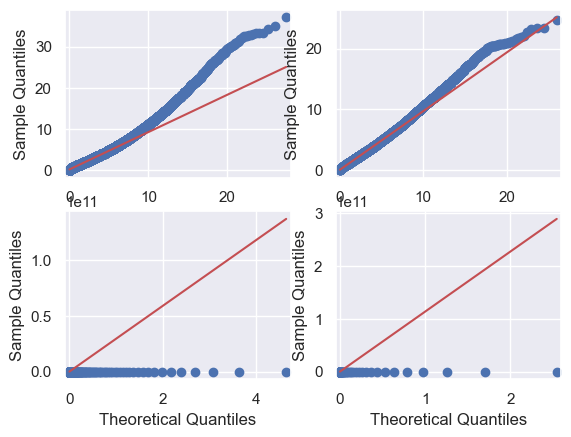

In [219]:
'''Graficas Q-Q '''
sns.set()
gqdur, axes = plt.subplots(2, 2)
sm.qqplot(data=energy1['duration.s'] , dist=stats.chi2 ,fit=True ,ax=axes[0,0], line= 'q')
sm.qqplot(data=energy2['duration.s'] , dist=stats.chi2 ,fit=True ,ax=axes[0,1], line= 'q')
sm.qqplot(data=energy3['duration.s'] , dist=stats.chi2 ,fit=True ,ax=axes[1,0], line= 'q')
sm.qqplot(data=energy4['duration.s'] , dist=stats.chi2 ,fit=True ,ax=axes[1,1], line= 'q')
figqdur = gqdur.get_figure()
figqdur.savefig("GraficaQQduracion.png")

A continuación las graficas intercuantiles de las duraciones en segundos de las energias 25-50 , y 50-100 las cuales no se ajustan a la dist chi2 esto puede plantear que las duraciones tal vez no sigan una distribucion estadistica como tal, abusando del teorema del limite central se hacen q-q con respecto a la distribución normal aunque este no es un buen argumento para determinar si se ajustan a alguna distribucion pues tecnicamente al ser una muestra tan grande por el mismo teorema tiende a una distribucion normal

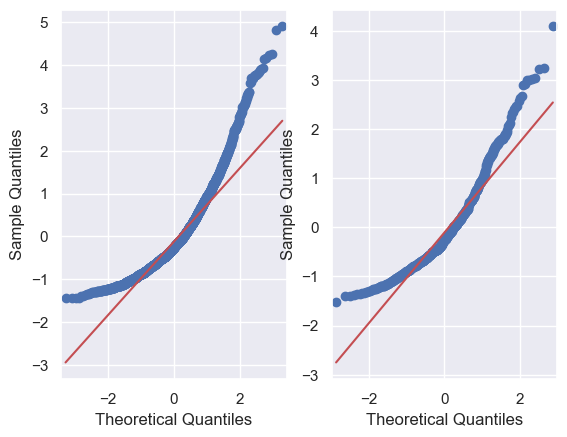

In [220]:
sns.set()
gqdurn, axes = plt.subplots(1, 2)
sm.qqplot(data=energy3['duration.s'] , dist=stats.norm ,fit=True , line= 'q', ax=axes[0])
sm.qqplot(data=energy4['duration.s'] , dist=stats.norm ,fit=True , line= 'q', ax=axes[1])
figqdurn = gqdurn.get_figure()
figqdurn.savefig("GraficaQQnormalDurEn34.png")

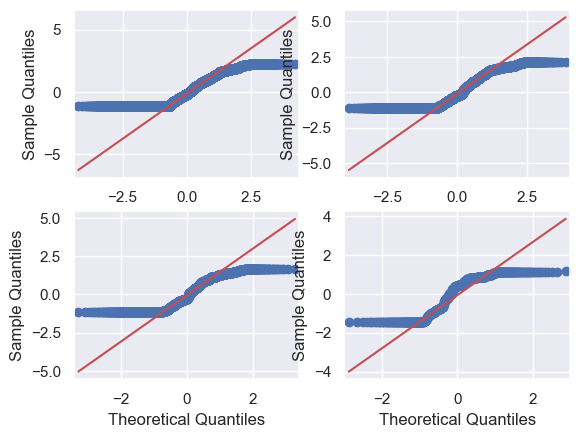

In [217]:
sns.set()
gqar, axes = plt.subplots(2, 2)
sm.qqplot(data=energy1['active.region.ar'] , dist=stats.norm ,fit=True ,ax=axes[0,0], line= 'q')
sm.qqplot(data=energy2['active.region.ar'] , dist=stats.norm ,fit=True ,ax=axes[0,1], line= 'q')
sm.qqplot(data=energy3['active.region.ar'] , dist=stats.norm ,fit=True ,ax=axes[1,0], line= 'q')
sm.qqplot(data=energy4['active.region.ar'] , dist=stats.norm ,fit=True ,ax=axes[1,1], line= 'q')
figqar = gqar.get_figure()
figqar.savefig("GraficaQQRegionActiva.png")

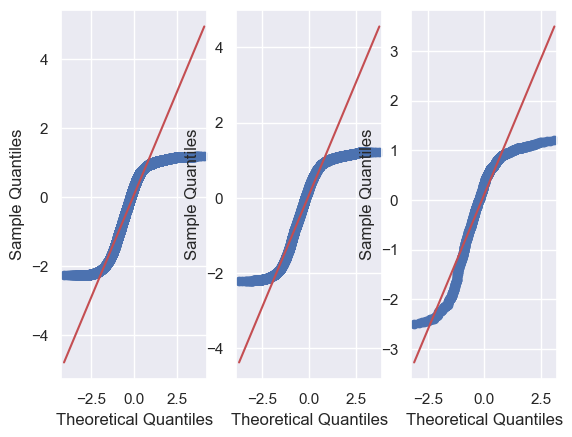

In [223]:
sns.set()
gqposx, axes = plt.subplots(1, 3)
sm.qqplot(data=energypox1['x.pos.asec'] , dist=stats.norm ,fit=True ,ax=axes[0], line= 'q')
sm.qqplot(data=energypox2['x.pos.asec'] , dist=stats.norm ,fit=True ,ax=axes[1], line= 'q')
sm.qqplot(data=energypox3['x.pos.asec'] , dist=stats.norm ,fit=True ,ax=axes[2], line= 'q')
figposx = gqposx.get_figure()
figposx.savefig("GraficaQQPosX.png")

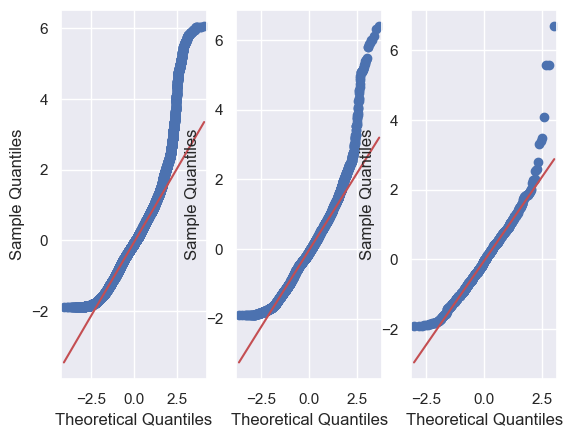

In [224]:
sns.set()
gqposy, axes = plt.subplots(1, 3)
sm.qqplot(data=energypoy1['y.pos.asec'] , dist=stats.norm ,fit=True ,ax=axes[0], line= 'q')
sm.qqplot(data=energypoy2['y.pos.asec'] , dist=stats.norm ,fit=True ,ax=axes[1], line= 'q')
sm.qqplot(data=energypoy3['y.pos.asec'] , dist=stats.norm ,fit=True ,ax=axes[2], line= 'q')
figposy = gqposy.get_figure()
figposy.savefig("GraficaQQPosy.png")

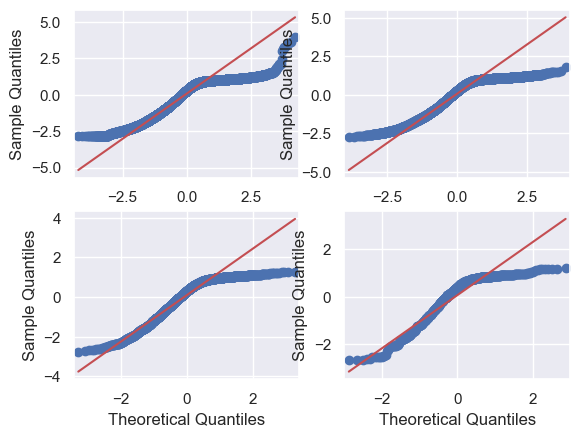

In [248]:
sns.set()
gqrad, axes = plt.subplots(2, 2)
sm.qqplot(data=energy1['radial'] , dist=stats.norm ,fit=True ,ax=axes[0,0], line= 'q')
sm.qqplot(data=energy2['radial'] , dist=stats.norm ,fit=True ,ax=axes[0,1], line= 'q')
sm.qqplot(data=energy3['radial'] , dist=stats.norm ,fit=True ,ax=axes[1,0], line= 'q')
sm.qqplot(data=energy4['radial'] , dist=stats.norm ,fit=True ,ax=axes[1,1], line= 'q')
figqrad = gqrad.get_figure()
figqrad.savefig("GraficaQQRad.png")

esto genera tal vez la sospecha de que las propias duraciones dependiendo del rango de energia tienen distribuciones distintas, esto justo puede tambien
puede llevar la discución a ciertas caracteristicas temporales de las llamaradas tales como el efecto nuepert que relaciona la forma funcional de las energias de rayos X de alta frecuencia es proporcional a la derivada temporal de la forma funcional de las llamaradas de energias con rayos X de baja frecuencias. Estas dos energias tienen una relación causal de la cual se habla en otras investigaciones.
$$
F(t)_{HXR}=\frac{\delta F(t)_{SHR}}{\delta t}
$$
En la siguiente celda se tienen las funciones para las pruebas estadisticas con respecto a las medias con la distribucion T de student, la prueba de proporcion de varianzas F de fisher y la prueba para un valor medio con la distribucion normal y aunque se tienen valores p 'positivos' realmente por la alta varianza de cada uno de los rangos no se puede confiar en ese ajuste

In [114]:
'''Funcion para prueba estadistica t student'''
def PDMT(dfa,dfb,col,alpha,hip):
# se sacan los promedios, el numero de muestras y las desviaciones estandar con n-1 grados de libertad 'ddof'
    proa=dfa[col].mean()
    prob=dfb[col].mean()
    na=len(dfa[col])
    nb=len(dfb[col])
    sta=dfa[col].std(ddof=(na-1))
    stb=dfb[col].std(ddof=(nb-1))
# se hace la diferencia de las medias muestrales y se calculan los grados de libertad para una t student de 
# dos variables aleatorios con varianzas diferentes y desconocidas esta se lleva al entero menor (aproximación de scatterhwaite)
    Promdif=prob-proa
    v=pow((pow(sta,2)/na)+(pow(stb,2)/nb),2)/((pow(pow(sta,2)/na,2)/na-1)+(pow(pow(stb,2)/nb,2)/nb-1))
    kv=int(v)
# se definen el t estadistico de la prueba Test y el valor critico de una distibucion t de student
# con kv grados de libertad , con un indice de sigfinicancia del 0.05 
    Tdeno=np.sqrt((pow(sta,2)/na)+(pow(stb,2)/nb))
    Tnume=(Promdif-hip)
    Test=Tnume/Tdeno
    conf=(1.0-alpha)
    cv=stats.t.ppf(conf, kv)
#intervalos de confianza a partir del valor v y se determina el valor estadistico p para la hipotesis nula de que mu_a=mu_b
    coin=Tnume-(cv*np.sqrt((pow(sta,2)/na)+(pow(stb,2)/nb)))
    coif=Tnume+(cv*np.sqrt((pow(sta,2)/na)+(pow(stb,2)/nb)))
    ps=1-sc.special.stdtr(kv,np.abs(Test))
    #p=(1.0-stats.t.cdf(np.abs(Test),kv))
    return Test, coin, coif, cv, ps, Promdif

'''Funcion prueba estadistica F de fisher'''
def PDVF(dfa,dfb,col,alpha):
# se definen las medias muestrales, el numero de muestras, los grados de libertad de cada muestra y las desviaciones estandar
# con los respectivos grados de libertad de las muestras
    pro1=dfa[col].mean()
    pro2=dfb[col].mean()
    n1=len(dfa[col])
    n2=len(dfb[col])
    dof1=(n1-1)
    dof2=(n2-1)
    st1=dfa[col].std(ddof=dof1)
    st2=dfb[col].std(ddof=dof2)
# grado de significancia alpha=0.025, intervalo de confianza, F valor critico, , F estadistico, y valor p 
    finf=(1/stats.f.ppf(alpha,dof1,dof2))
    fsup=(1/stats.f.ppf(1-alpha,dof1,dof2))
    Fest=pow(st1,2)/pow(st2,2)
    coin=Fest*finf
    coif=Fest*fsup
    pf=1-stats.f.cdf(abs(Fest),dof1,dof2)
    return coif, coin, Fest , pf ,fsup

'''Funcion prueba estadistica t student para una media de posicion'''
def PDMTU(dfa,col,alpha,hip):
    n=len(dfa[col])
    dof=n-1
    conf=1-alpha
    std=dfa[col].std(ddof=dof)
    prom=dfa[col].mean()
    cv=stats.t.ppf(conf,dof)
    Tden=std/np.sqrt(n)
    T=(prom-hip)/Tden
    p=1-stats.t.cdf(abs(T),dof)
    coin=prom-cv*(std/np.sqrt(n))
    coif=prom+cv*(std/np.sqrt(n))
    return cv, coin, coif, p ,T

'''funcion para calcular el valor critico chi-cuadrado para valores de libertad de la muestra para el analisis del error'''
def PERROR(dfa,y,alpha):
    ip=0
    chil=[]
    for i in range(min(dfa),max(dfa)-1):
        chil=pow(dfa[i]-y,2)/(dfa[i])
        ip=ip+1
    n=ip
    dof=n-1
    conf=1-alpha
    cv=stats.chi2.ppf(conf,dof)
    chi2=chil.sum()
    return cv, chi2

In [115]:
# pruebas estadisticas para la diferencia del valor medio de la duracion entre dos poblaciones categorizadas por su energia T de student 
# defina su hipotesis
hipt1=0
hipt2=400
hipt3=200
# T test para energias 6-12 y 12-25 , 12-25 y 25-50
Test12, coin12, coif12, cv12, ps12, Promdif12=PDMT(energy1,energy2,'duration.s',0.025,hipt1)
Test23, coin23, coif23, cv23, ps23, Promdif23=PDMT(energy2,energy3,'duration.s',0.025,hipt1)
# pruebas estadisticas para la proporcion de las varianzas de dos poblaciones categorizadas por energia con F de fisher 
# pruebas F de fisher para energias 6-12 y 12-25 para las duraciones
coifdur12, coindur12, Festdur12 , pfdur12, fsupdur12 = PDVF(energy1,energy2,'duration.s',0.05)
coifdur23, coindur23, Festdur23 , pfdur23, fsupdur23 = PDVF(energy2,energy3,'duration.s',0.05)
# pruebas F de fisher para energias 12-25 y 25-50 para las posiciones en x
coifpx12, coinpx12, Festpx12 , pfpx12 ,fsupx12 = PDVF(energypox1,energypox2,'x.pos.asec',0.05)
coifpx23, coinpx23, Festpx23 , pfpx23 ,fsupx23 = PDVF(energypox2,energypox3,'x.pos.asec',0.05)
# pruebas F de fisher para energias 12-25 y 25-50 para las posiciones en y
coifpy12, coinpy12, Festpy12 , pfpy12 ,fsupy12 = PDVF(energypoy1,energypoy2,'y.pos.asec',0.05)
coifpy23, coinpy23, Festpy23 , pfpy23 ,fsupy23 = PDVF(energypoy2,energypoy3,'y.pos.asec',0.05)
# prueba estadistica t student para determinar la media de la posicion x de las energias 6-12 y 12-25
cvnpx1, coinpx1, coifpx1, ppx1 ,Tpx1 = PDMTU(energypox1,'x.pos.asec',0.025,hipt2)
cvnpx2, coinpx2, coifpx2, ppx2 ,Tpx2 = PDMTU(energypox2,'x.pos.asec',0.025,hipt2) 
# prueba estadistica t student para determinar la media de la posicion y de las energias 6-12 y 12-25
cvnpy1, coinpy1, coifpy1, ppy1, Tpy1 = PDMTU(energypoy1,'y.pos.asec',0.025,hipt3)
cvnpy2, coinpy2, coifpy2, ppy2, Tpy2 = PDMTU(energypoy2,'y.pos.asec',0.025,hipt3) 
#RESULTADOS ENERGIAS 6-12 12-25
print('T estadistico para las energias 6-12 y 12-25: ',Test12,' intervalo de confianza con un 0.05 de significancia para enegias 6-12 y 12-25:(',coin12,',',coif12,')')
print('T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 6-12 y 12-25:',cv12)
print('valor p estadistica para la hipotesis nula 0 (la hipotesis nula es que las diferencia de las medias es 0)',ps12)

T estadistico para las energias 6-12 y 12-25:  0.5718788963651211  intervalo de confianza con un 0.05 de significancia para enegias 6-12 y 12-25:( -896.4360254728241 , 1635.0477372110286 )
T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 6-12 y 12-25: 1.9600313904621558
valor p estadistica para la hipotesis nula 0 (la hipotesis nula es que las diferencia de las medias es 0) 0.28370383722464476


In [116]:
#RESULTADOS ENERGIAS 12-25 25-50
print('T estadistico para las energias 12-25 y 25-50: ',Test23,' intervalo de confianza con un 0.05 de significancia para enegias 12-25 y 25-50:(',coin23,',',coif23,')')
print('T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 12-25 y 25-50:',cv23)
print('valor p estadistica para la hipotesis nula 0 (la hipotesis nula es que las diferencia de las medias es 0)',ps23)

T estadistico para las energias 12-25 y 25-50:  0.27141445678543297  intervalo de confianza con un 0.05 de significancia para enegias 12-25 y 25-50:( -1497.4103374776205 , 1978.6605977422114 )
T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 12-25 y 25-50: 1.9604267935597812
valor p estadistica para la hipotesis nula 0 (la hipotesis nula es que las diferencia de las medias es 0) 0.3930416057840319


In [117]:
#Resultados Energias 6-12 12-25 para la duracion proporcion de varianzas F de Fisher
print('F estadistico para las energias 6-12 y 12-25: ',Festdur12,' intervalo de confianza con un 0.05 de significancia para enegias 6-12 y 12-25:(',coifdur12,',',coindur12,')')
print('F critico para los grados de libertad de la muestra (chi cuadrada con N-1 grados de libertad) para energias 6-12 y 12-25:',fsupdur12)
print('valor p estadistica para la hipotesis nula (la hipotesis nula es que las proporcion de las varianzas es 1)',pfdur12)

F estadistico para las energias 6-12 y 12-25:  1.677028865631583  intervalo de confianza con un 0.05 de significancia para enegias 6-12 y 12-25:( 1.6460508958578852 , 1.7083730292031158 )
F critico para los grados de libertad de la muestra (chi cuadrada con N-1 grados de libertad) para energias 6-12 y 12-25: 0.9815280640610612
valor p estadistica para la hipotesis nula (la hipotesis nula es que las proporcion de las varianzas es 1) 1.1102230246251565e-16


In [118]:
#Resultados Energias 12-25 25-50 para la duracion proporcion de varianzas F de Fisher
print('F estadistico para las energias 12-25 y 25-50: ',Festdur23,' intervalo de confianza con un 0.05 de significancia para enegias 12-25 y 25-50:(',coifdur23,',',coindur23,')')
print('F critico para los grados de libertad de las muestras (chi cuadradas con N-1 grados de libertad) para energias 12-25 y 25-50:',fsupdur23)
print('valor p estadistica para la hipotesis nula (la hipotesis nula es que las proporcion de las varianzas es 1)',pfdur23)

F estadistico para las energias 12-25 y 25-50:  5.97750014592749  intervalo de confianza con un 0.05 de significancia para enegias 12-25 y 25-50:( 5.656513514543304 , 6.307899699347562 )
F critico para los grados de libertad de las muestras (chi cuadradas con N-1 grados de libertad) para energias 12-25 y 25-50: 0.9463008576247588
valor p estadistica para la hipotesis nula (la hipotesis nula es que las proporcion de las varianzas es 1) 1.1102230246251565e-16


In [119]:
#Resultados Energias 6-12 12-25 para la posicion x coon la proporcion de varianzas 1 para F de Fisher
print('F estadistico para las energias 6-12 y 12-25: ',Festpx12,' intervalo de confianza con un 0.05 de significancia para enegias 6-12 y 12-25:(',coifpx12,',',coinpx12,')')
print('F critico para los grados de libertad de las muesFestpx12tras (chi cuadradas con N-1 grados de libertad) para energias 6-12 y 12-25:',fsupx12)
print('valor p estadistica para la hipotesis nula (la hipotesis nula es que las proporcion de las varianzas es 1)',pfpx12)

F estadistico para las energias 6-12 y 12-25:  4.385598713184281  intervalo de confianza con un 0.05 de significancia para enegias 6-12 y 12-25:( 4.271421640371737 , 4.501693029920359 )
F critico para los grados de libertad de las muesFestpx12tras (chi cuadradas con N-1 grados de libertad) para energias 6-12 y 12-25: 0.9739654536861074
valor p estadistica para la hipotesis nula (la hipotesis nula es que las proporcion de las varianzas es 1) 1.1102230246251565e-16


In [251]:
#Resultados Energias 12-25 25-50 para la posicion x con la proporcion de varianzas 1 para F de Fisher
print('F estadistico para las energias 12-25 y 25-50: ',Festpx23,' intervalo de confianza con un 0.05 de significancia para enegias 12-25 y 25-50:(',coifpx23,',',coinpx23,')')
print('F critico para los grados de libertad de las muesFestpx12tras (chi cuadradas con N-1 grados de libertad) para energias 12-25 y 25-50:',fsupx23)
print('valor p estadistica para la hipotesis nula (la hipotesis nula es que las proporcion de las varianzas es 1)',pfpx23)

F estadistico para las energias 12-25 y 25-50:  10.905103164770757  intervalo de confianza con un 0.05 de significancia para enegias 12-25 y 25-50:( 10.087532027761668 , 11.756620963908654 )
F critico para los grados de libertad de las muesFestpx12tras (chi cuadradas con N-1 grados de libertad) para energias 12-25 y 25-50: 0.925028573810262
valor p estadistica para la hipotesis nula (la hipotesis nula es que las proporcion de las varianzas es 1) 1.1102230246251565e-16


In [252]:
#Resultados Energias 12-25 25-50 para la posicion y proporcion de varianzas F de Fisher
print('F estadistico para las energias 12-25 y 25-50: ',Festpy23,' intervalo de confianza con un 0.05 de significancia para enegias  12-25:(',coifpy23,',',coinpy23,')')
print('F critico para los grados de libertad de las muesFestpx12tras (chi cuadradas con N-1 grados de libertad) para energias 6-12 y 12-25:',fsupy23)
print('valor p estadistica para la hipotesis nula (la hipotesis nula es que las proporcion de las varianzas es 1)',pfpy23)

F estadistico para las energias 12-25 y 25-50:  10.558183015440878  intervalo de confianza con un 0.05 de significancia para enegias  12-25:( 9.688698449768085 , 11.467545093956996 )
F critico para los grados de libertad de las muesFestpx12tras (chi cuadradas con N-1 grados de libertad) para energias 6-12 y 12-25: 0.9176482767535653
valor p estadistica para la hipotesis nula (la hipotesis nula es que las proporcion de las varianzas es 1) 1.1102230246251565e-16


In [122]:
#Resultados posicion x para las energias 6-12
print('T estadistico para las energias 6-12:',Tpx1,' intervalo de confianza con un 0.05 de significancia para enegias 6-12:(',coinpx1,',',coifpx1,')')
print('T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 6-12:',cvnpx1)
print('valor p estadistica para la hipotesis nula 0 (la hipotesis nula de que el promedio poblacional es se encuentra alrededor de 400)',ppx1)

T estadistico para las energias 6-12: 0.8820180152625949  intervalo de confianza con un 0.05 de significancia para enegias 6-12:( 88.45574923797119 , 1221.3535192955692 )
T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 6-12: 1.960019764873856
valor p estadistica para la hipotesis nula 0 (la hipotesis nula de que el promedio poblacional es se encuentra alrededor de 400) 0.18888602499034635


In [123]:
#Resultados posicion x para las energias 12-25
print('T estadistico para las energias 12-25:',Tpx2,' intervalo de confianza con un 0.05 de significancia para enegias 12-25:(',coinpx2,',',coifpx2,')')
print('T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 12-25:',cvnpx2)
print('valor p estadistica para la hipotesis nula 0 (la hipotesis nula de que el promedio poblacional es se encuentra alrededor de 400)',ppx2)

T estadistico para las energias 12-25: 0.8296570909460297  intervalo de confianza con un 0.05 de significancia para enegias 12-25:( 72.11879517485715 , 1209.1127728417578 )
T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 12-25: 1.9602103823365704
valor p estadistica para la hipotesis nula 0 (la hipotesis nula de que el promedio poblacional es se encuentra alrededor de 400) 0.2033766277431629


In [124]:
#Resultados posicion y para las energias 6-12
print('T estadistico para las energias 6-12:',Tpy1,' intervalo de confianza con un 0.05 de significancia para enegias 6-12:(',coinpy1,',',coifpy1,')')
print('T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 6-12:',cvnpy1)
print('valor p estadistica para la hipotesis nula 0 (la hipotesis nula de que el promedio poblacional es se encuentra alrededor de 400)',ppy1)

T estadistico para las energias 6-12: 0.2902147257492325  intervalo de confianza con un 0.05 de significancia para enegias 6-12:( -7.808189516210945 , 480.04267009053524 )
T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 6-12: 1.960026600892098
valor p estadistica para la hipotesis nula 0 (la hipotesis nula de que el promedio poblacional es se encuentra alrededor de 400) 0.38582677979101754


In [125]:
#Resultados posicion y para las energias 12-25
print('T estadistico para las energias 6-12:',Tpy2,' intervalo de confianza con un 0.05 de significancia para enegias 6-12:(',coinpy2,',',coifpy2,')')
print('T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 6-12:',cvnpy2)
print('valor p estadistica para la hipotesis nula 0 (la hipotesis nula de que el promedio poblacional es se encuentra alrededor de 400)',ppy2)

T estadistico para las energias 6-12: 0.22271034607106943  intervalo de confianza con un 0.05 de significancia para enegias 6-12:( -5.887803250277557 , 458.6669878539747 )
T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 6-12: 1.9602644313787672
valor p estadistica para la hipotesis nula 0 (la hipotesis nula de que el promedio poblacional es se encuentra alrededor de 400) 0.41188335417431843


Con lo anterior se pueden concluir la siguientes cosas con respecto a las pruebas realizadas para la distribucion T de student para las medias de las duraciones y es que aunque los valores den mayores a los de significancia esto es por que la varianza de los datos es extremadamente alta por lo que el intervalo de apreciación para los valores de la duracion se hace muy ancho por lo que las diferencias siempre quedan dentro del intervalo, esto muestra que no es un ajuste muy confiable para determinar tanto si son poblaciones con medias iguales o si quiera si son diferentes, al trabajar con una F de fisher la proporcion de las varianzas bajo la misma hipotesis nula si se puede obtener un resultado determinante pues los p valores de la prueba nos permiten rechazar la hipotesis en que las medias de las poblaciones son iguales o que la proporcion de sus varianzas es 1, con respecto a las pruebas t de student con respecto a las posicion x,y para determinar su media poblacional de las energias 6-12 , 12-25 es su intervalo de confianza y que la hipotesis nula (que el promedio es alrededor de 400) no puede ser rechazada.

$$
\textbf{Graficas aproximadas para las duraciones y posiciones de los rangos de energia 1,2 y 3}
$$

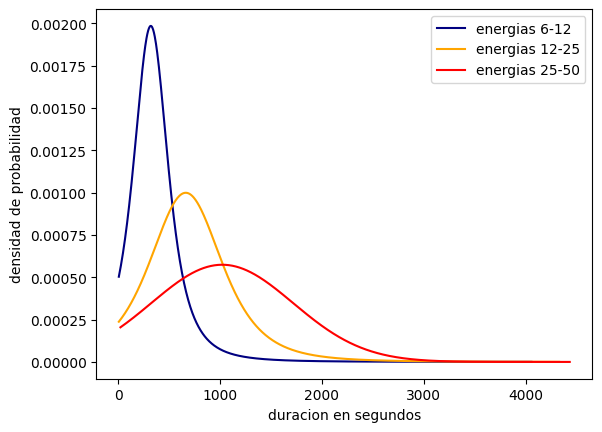

In [126]:
#Funcion que dibuja la curva aproximada dado un data frame la columna y la distribucion a la que se cree puede ajustarse
def AproxGra(dfa,col,dists):
    dist=dists
    paradist= dist.fit(data=dfa[col])
#este linspace va del valor minimo de la columna al valor maximo con 1000 saltos
    xd=np.linspace(dfa[col].min(),dfa[col].max(),1000)
    yd=dist.pdf(xd,*paradist)
    return xd, yd, paradist
# aproximacion de las duraciones para las energias 1,2 y 3 
x1,y1,p1 = AproxGra(energy1,'duration.s',stats.t)
x2,y2,p2 = AproxGra(energy2,'duration.s',stats.t)
x3,y3,p3 = AproxGra(energy3,'duration.s',stats.t)
# aproximacion las posiciones x para las energias 1,2 y 3 
xpos1,ypos1,px1par = AproxGra(energypox1,'x.pos.asec',stats.norm)
xpos2,ypos2,px2par = AproxGra(energypox2,'x.pos.asec',stats.norm)
xpos3,ypos3,px3par = AproxGra(energypox3,'x.pos.asec',stats.norm)
# aproximacion de las posiciones en y para las energias 1,2 y 3
xposy1,yposy1,px1pary = AproxGra(energypoy1,'y.pos.asec',stats.norm)
xposy2,yposy2,px2pary = AproxGra(energypoy2,'y.pos.asec',stats.norm)
xposy3,yposy3,px3pary = AproxGra(energypoy3,'y.pos.asec',stats.norm)
#grafica de la aproximacion de la duracion
plt.figure()
plt.plot(x1,y1,label='energias 6-12',color='navy')
plt.plot(x2,y2,label='energias 12-25',color='orange')
plt.plot(x3,y3,label='energias 25-50',color='red')
plt.ylabel('densidad de probabilidad')
plt.xlabel('duracion en segundos')
plt.legend()

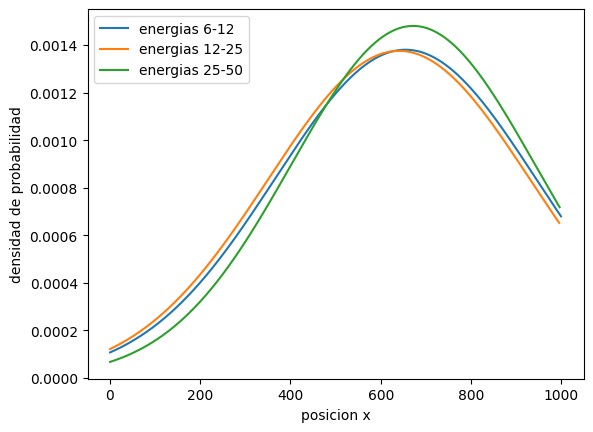

In [127]:
#sns.histplot(data=energy1,x='duration.s')
plt.figure()
plt.plot(xpos1,ypos1,label='energias 6-12')
plt.plot(xpos2,ypos2,label='energias 12-25')
plt.plot(xpos3,ypos3,label='energias 25-50')
plt.legend()
plt.ylabel('densidad de probabilidad')
plt.xlabel('posicion x')
plt.show()

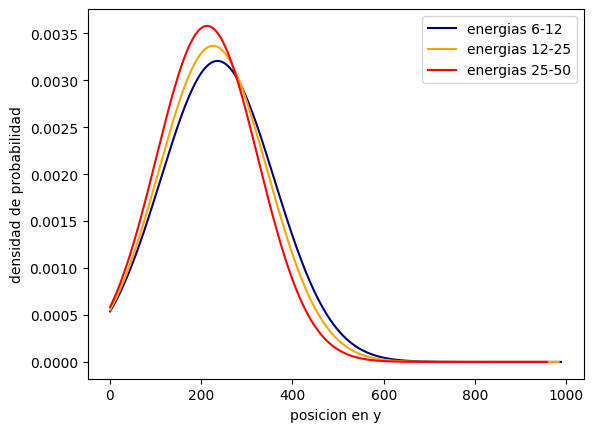

In [128]:
plt.figure()
plt.plot(xposy1,yposy1,label='energias 6-12',color='navy')
plt.plot(xposy2,yposy2,label='energias 12-25',color='orange')
plt.plot(xposy3,yposy3,label='energias 25-50',color='red')
plt.ylabel('densidad de probabilidad')
plt.xlabel('posicion en y')
plt.legend()

$$
\textbf{Prueba de errores chi cuadrada para bondad de los ajustes}
$$
la prueba chi cuadrada para la bondad del ajuste consiste en comparar las observaciones experimentales y las aproximadas para compararlas con un estadistico chi-cuadrado y determinar si entra en el area de aceptacion para un ajuste eficiente (debe ser menor a un valor critico chi-cuadrado con n-1 grados de libertad (pares de observaciones)
$$
X^{2}=\frac{\sum_{i=0}^{k}(e-o)^{2}}{e}
$$
por ultimo si la variable $x^2$ es mayor a una variable chi-2 con los mismos grados de libertad , pero con un indice de significancia de $\alpha=$0.05, osea si $x^2>x_{\alpha}^{2}$ se considera que el ajuste es deficiente

In [129]:
ErrorEnergydur1=energy1.sort_values(ascending=True,by='duration.s')
ErrorEnergydur2=energy2.sort_values(ascending=True,by='duration.s')
ListaEnergydur1=ErrorEnergydur1['duration.s']
ListaEnergydur2=ErrorEnergydur2['duration.s']
cdurst1,cdure1 =PERROR(ListaEnergydur1,y1,0.05)
cdurst2,cdure2 =PERROR(ListaEnergydur2,y2,0.05)
print('Errores para las duraciones')
print('chi-cuadrado estadistico para la duracion de las energias 6-12',cdurst1,'el chi-cuadrado del error calculado es de',cdure1)
print('chi-cuadrado estadistico para la duracion de las energias 12-25',cdurst2,'el chi-cuadrado del error calculado es de',cdure2)
#por alguna razón la funcion no puede calcular el error para este aproximacion
#ErrorEnergydur3=energy3.sort_values(ascending=True,by='duration.s')
#ListaEnergydur3=ErrorEnergydur3['duration.s']
#cdurst3,cdure3 =PERROR(ListaEnergydur3,y3,0.05)
#print('chi-cuadrado estadistico para la duracion de las energias 25-50',cdurst3,'el chi-cuadrado del error calculado es de',cdure3)

Errores para las duraciones
chi-cuadrado estadistico para la duracion de las energias 6-12 4195.091977645238 el chi-cuadrado del error calculado es de 83999.55651482785
chi-cuadrado estadistico para la duracion de las energias 12-25 4471.984936230937 el chi-cuadrado del error calculado es de 367999.57585341996


In [130]:
ErrorEnergyposx1=energypox1.sort_values(ascending=True,by='x.pos.asec')
ErrorEnergyposx2=energypox2.sort_values(ascending=True,by='x.pos.asec')
ErrorEnergyposx3=energypox3.sort_values(ascending=True,by='x.pos.asec')
ListaEnergyposx1=ErrorEnergyposx1['x.pos.asec']
ListaEnergyposx2=ErrorEnergyposx2['x.pos.asec']
ListaEnergyposx3=ErrorEnergyposx3['x.pos.asec']
cposxst1,cposxe1 =PERROR(ListaEnergyposx1,ypos1,0.05)
cposxst2,cposxe2 =PERROR(ListaEnergyposx2,ypos2,0.05)
cposxst3,cposxe3 =PERROR(ListaEnergyposx3,ypos3,0.05)
print('Errores para las posiciones en x')
print('chi-cuadrado estadistico para la posicion en x de las energias 6-12',cposxst1,'el chi-cuadrado del error calculado es de',cposxe1)
print('chi-cuadrado estadistico para la posicion en x de las energias 12-25',cposxst2,'el chi-cuadrado del error calculado es de',cposxe2)
print('chi-cuadrado estadistico para la posicion en x de las energias 25-50',cposxst3,'el chi-cuadrado del error calculado es de',abs(cposxe3))

Errores para las posiciones en x
chi-cuadrado estadistico para la posicion en x de las energias 6-12 1070.5321455219273 el chi-cuadrado del error calculado es de 39998.25494695939
chi-cuadrado estadistico para la posicion en x de las energias 12-25 1066.3845460076836 el chi-cuadrado del error calculado es de 166998.23958143446
chi-cuadrado estadistico para la posicion en x de las energias 25-50 1067.421473755887 el chi-cuadrado del error calculado es de 962998.2338351156


In [131]:
ErrorEnergyposy1=energypoy1.sort_values(ascending=True,by='y.pos.asec')
ErrorEnergyposy2=energypoy2.sort_values(ascending=True,by='y.pos.asec')
#ErrorEnergyposy3=energypoy3.sort_values(ascending=True,by='y.pos.asec')
ListaEnergyposy1=ErrorEnergyposy1['y.pos.asec']
ListaEnergyposy2=ErrorEnergyposy2['y.pos.asec']
#ListaEnergyposy3=ErrorEnergyposy3['y.pos.asec']
cposyst1,cposye1 =PERROR(ListaEnergyposy1,yposy1,0.05)
cposyst2,cposye2 =PERROR(ListaEnergyposy2,yposy2,0.05)
#cposyst3,cposye3 =PERROR(ListaEnergyposy3,yposy3,0.05)
print('Errores para las posiciones en y')
print('chi-cuadrado estadistico para la posicion en y de las energias 6-12',cposyst1,'el chi-cuadrado del error calculado es de',cposye1)
print('chi-cuadrado estadistico para la posicion en y de las energias 12-25',cposyst2,'el chi-cuadrado del error calculado es de',abs(cposye2))
#print('chi-cuadrado estadistico para la posicion en y de las energias 25-50',cposyst3,'el chi-cuadrado del error calculado es de',abs(cposye3))
#print(len(energypoy3))

Errores para las posiciones en y
chi-cuadrado estadistico para la posicion en y de las energias 6-12 1059.1255286401802 el chi-cuadrado del error calculado es de 30998.034794858184
chi-cuadrado estadistico para la posicion en y de las energias 12-25 1053.9399520330298 el chi-cuadrado del error calculado es de 95998.0229946544


$$
\textbf{Conclusiones}
$$
A pesar de no tener unas buenas aproximaciones esto no significa que las llamaradas no tengan ciertas propiedades importantes a tener en cuenta que puedan relacionarlas, lo que ocurre es que estas manifestaciones luminicas son producto de procesos complejos que ocurren simultaneamente en la superficie solar. Y Aunque muchas de sus caracteristicas no tengan relaciones lineales si tienen relaciones causales. Por lo que el cambiar de enfoque a una categorización no se hace una idea descabellada, con esto en mente se plantearón justamente estas pruebas de hipotesis con respecto a las varianzas y así poder determinar si al menos las poblaciones eran caracteristicas de cada rango de energía. Por lo que a continuación se plantea distintos modelos de machine learning para clasificar el rango de energías de una llamarada solar(target) dados su posicion y duracion además de otros como la cuenta de picos por segundo entre otros (features), se tienen de las investigaciones de A. Veronig1 para los aspectos temporales y distribuciones de frecuencia de rayos X suaves se explica que en efecto por si solas las duraciones no toman una distribucion dada por una ley de potencias, sin embargo en este texto tambien definen a partir de la suposicion del efecto neupert una propiedad llamada flujo de picos, y fluencia como caracteristica sacadas de la relación entre el momento en el que ocurre el pico maximo de los rayos X de baja frecuencia y el momento de decaímiento de los rayos X de alta frecuencia. Esto se podria ver en esta base de datos con las columnas del final de las llamaradas de los rangos mayores de energia 50-100 keV y los del pico maximo de los valores de energia 25-50 

<AxesSubplot:title={'center':'Energy Range(KeV)'}, xlabel='Datetime'>

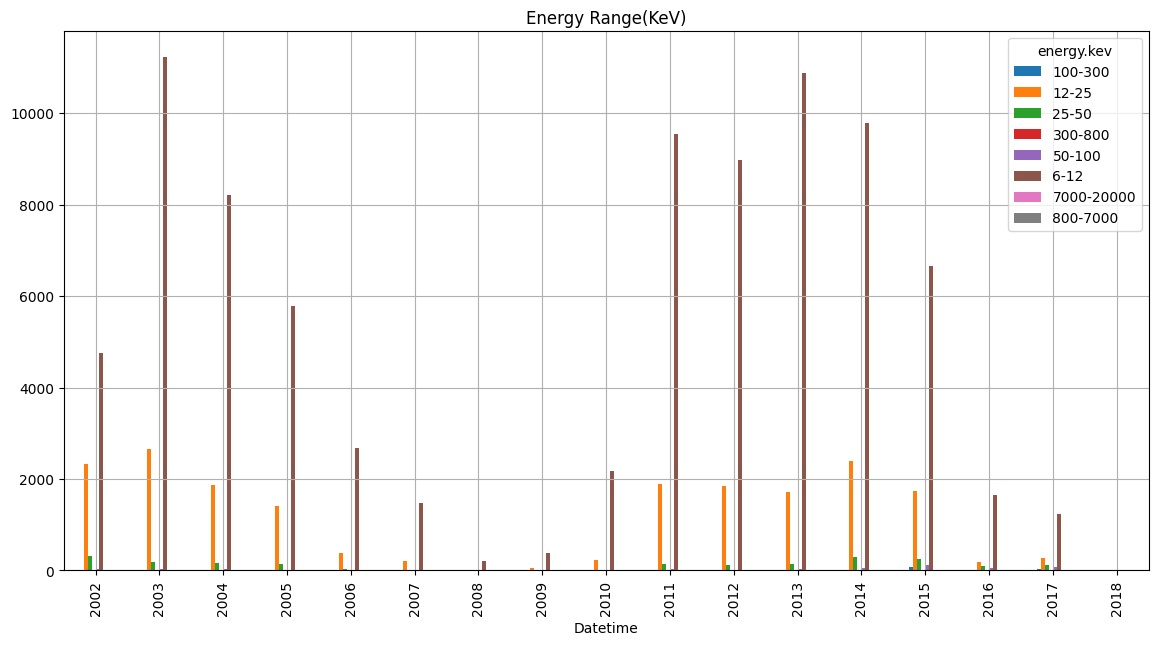

In [132]:
#analisis estandarizado
df.groupby([df.index.year])['energy.kev'].value_counts().unstack().plot(kind='bar', figsize=(14,7), title='Energy Range(KeV)'
                                                                       , style='ggplot', grid=True)

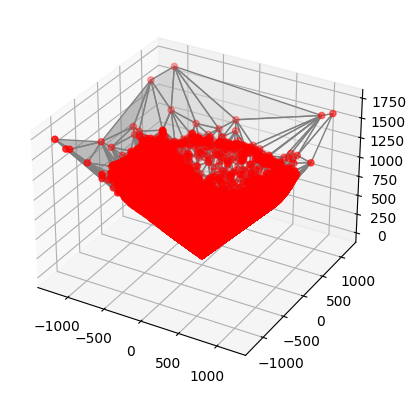

In [133]:
fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d') 
ax.plot_trisurf(df['x.pos.asec'], df['y.pos.asec'], df['radial'], color='white', edgecolors='grey', alpha=0.5) 
ax.scatter(df['x.pos.asec'], df['y.pos.asec'], df['radial'], c='red') 
plt.show()

$$ \textbf{PRUEBAS Y APROXIMACIONES PARA LAS COORDENADAS RADIALES Y REGION ACTIVA T DE STUDENT , F DE FISHER}$$

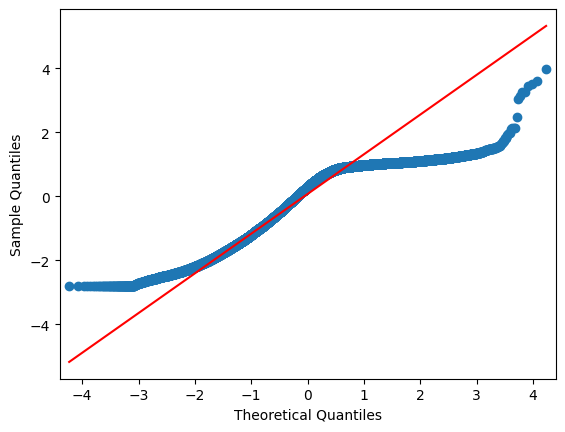

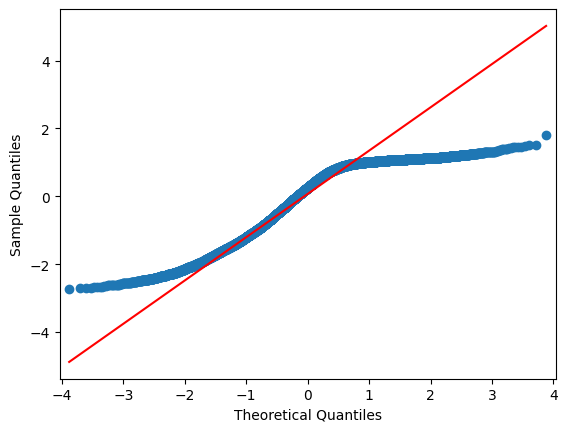

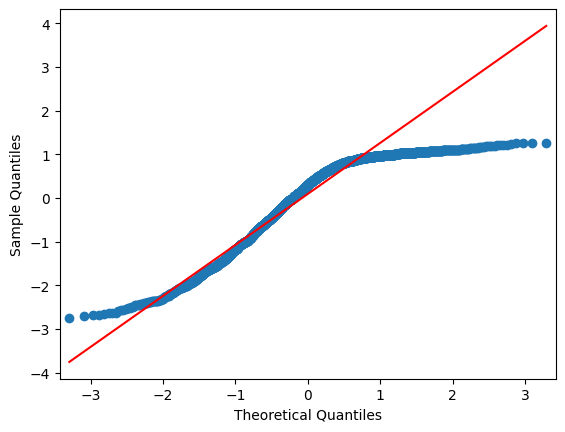

In [134]:
#radial
df.columns
gqnr1=sm.qqplot(data=energy1['radial'] , dist=stats.norm ,fit=True , line= 'q')
gqnr2=sm.qqplot(data=energy2['radial'] , dist=stats.norm ,fit=True , line= 'q')
gqnr3=sm.qqplot(data=energy3['radial'] , dist=stats.norm ,fit=True , line= 'q')

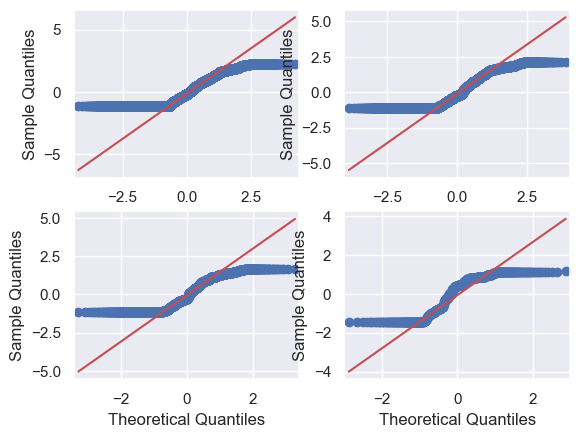

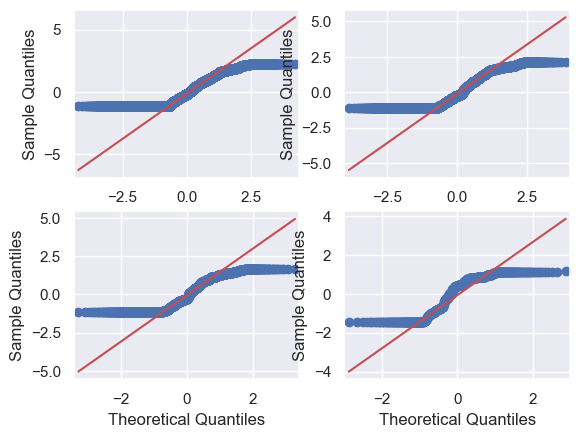

In [203]:
# active.region.ar
sns.set()
gqar, axes = plt.subplots(2, 2)
sm.qqplot(data=energy1['active.region.ar'] , dist=stats.norm ,fit=True ,ax=axes[0,0], line= 'q')
sm.qqplot(data=energy2['active.region.ar'] , dist=stats.norm ,fit=True ,ax=axes[0,1], line= 'q')
sm.qqplot(data=energy3['active.region.ar'] , dist=stats.norm ,fit=True ,ax=axes[1,0], line= 'q')
sm.qqplot(data=energy4['active.region.ar'] , dist=stats.norm ,fit=True ,ax=axes[1,1], line= 'q')

In [239]:
# orden de los return 
# F de fisher coif, coin, Fest , pf ,fsup PDVF
# T student Test, coin, coif, cv, ps, Promdif PDMT
# T para una media cv, coin, coif, p ,T PDMTU
PruebaTstudentRegionActiva=PDMT(energy1,energy2,'active.region.ar',0.025,hipt1)
PruebaTstudentRegionActiva2=PDMT(energy2,energy3,'active.region.ar',0.025,hipt1)
PruebaFvarRegionActiva1 = PDVF(energy2,df,'active.region.ar',0.05)
PruebaFvarRegionActiva2 = PDVF(energy1,energy2,'active.region.ar',0.05)

In [242]:
print('T estadistico',PruebaTstudentRegionActiva[0],'intervalo de confianza (',PruebaTstudentRegionActiva[1],',',PruebaTstudentRegionActiva[2],')')
print('valor p vara la hipotesis de medias iguales p:',PruebaTstudentRegionActiva[4],)
print('prueba F de fisher de proporcion de varianzas para el rango 12-25 con todos los demas')
print('intervalo de confianza (',PruebaFvarRegionActiva1[1],',',PruebaFvarRegionActiva1[0],') F estadistico:',PruebaFvarRegionActiva1[2])
print('valor p:',PruebaFvarRegionActiva1[3])
print('prueba F de fisher de proporcion de varianzas para el rango 6-12 y 12-25')
print('intervalo de confianza (',PruebaFvarRegionActiva2[1],',',PruebaFvarRegionActiva2[0],') F estadistico:',PruebaFvarRegionActiva2[2])
print('valor p:',PruebaFvarRegionActiva2[3])
#print(PruebaFvarRegionActiva1)

T estadistico 0.0010170982712560121 intervalo de confianza ( -2259.6168771194807 , 2261.9632454855337 )
valor p vara la hipotesis de medias iguales p: 0.4995942382762628
prueba F de fisher de proporcion de varianzas para el rango 12-25 con todos los demas
intervalo de confianza ( 0.1916887518975831 , 0.18482508367173298 ) F estadistico: 0.188212990448715
valor p: 1.0
prueba F de fisher de proporcion de varianzas para el rango 6-12 y 12-25
intervalo de confianza ( 4.169261243006033 , 4.0171649205424735 ) F estadistico: 4.092766236271941
valor p: 1.1102230246251565e-16


In [246]:
PruebaTstudentRadial1=PDMT(energy1,energy2,'radial',0.025,hipt1)
PruebaTstudentRadial2=PDMT(energy2,energy3,'radial',0.025,hipt1)
PruebaFvarRadial1 = PDVF(energy1,df,'radial',0.05)
PruebaFvarRadial2 = PDVF(energy1,energy2,'radial',0.05)

In [247]:
print('T estadistico',PruebaTstudentRadial1[0],'intervalo de confianza (',PruebaTstudentRadial1[1],',',PruebaTstudentRadial1[2],')')
print('valor p vara la hipotesis de medias iguales p:',PruebaTstudentRadial1[4],)
print('prueba F de fisher de proporcion de varianzas para el rango 12-25 con todos los demas')
print('intervalo de confianza (',PruebaFvarRadial1[1],',',PruebaFvarRadial1[0],') F estadistico:',PruebaFvarRadial1[2])
print('valor p:',PruebaFvarRadial1[3])
print('prueba F de fisher de proporcion de varianzas para el rango 6-12 y 12-25')
print('intervalo de confianza (',PruebaFvarRadial2[1],',',PruebaFvarRadial2[0],') F estadistico:',PruebaFvarRadial2[2])
print('valor p:',PruebaFvarRadial2[3])

T estadistico -0.03870601637768582 intervalo de confianza ( -721.2449370341534 , 693.3103694777632 )
valor p vara la hipotesis de medias iguales p: 0.48456244978949325
prueba F de fisher de proporcion de varianzas para el rango 12-25 con todos los demas
intervalo de confianza ( 0.8068339491472932 , 0.7898243765979888 ) F estadistico: 0.7982808811836801
valor p: 1.0
prueba F de fisher de proporcion de varianzas para el rango 6-12 y 12-25
intervalo de confianza ( 4.564291306439748 , 4.397784128812915 ) F estadistico: 4.480548534309995
valor p: 1.1102230246251565e-16


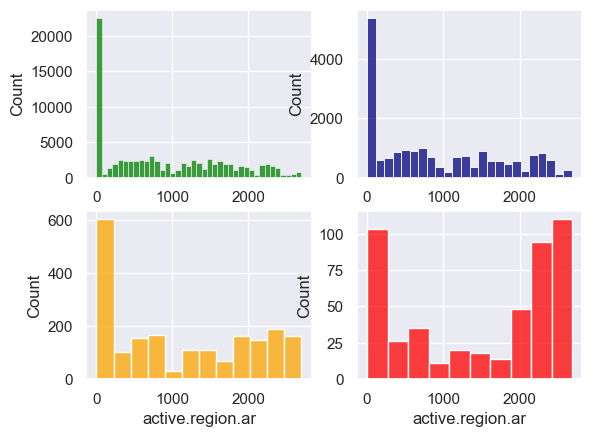

In [192]:
sns.set()
ghar, axes = plt.subplots(2, 2)
sns.histplot(data=energy1,x='active.region.ar',ax=axes[0,0],color='green')
sns.histplot(data=energy2,x='active.region.ar',ax=axes[0,1],color='navy')
sns.histplot(data=energy3,x='active.region.ar',ax=axes[1,0],color='orange')
sns.histplot(data=energy4,x='active.region.ar',ax=axes[1,1],color='red')
fighar=ghar.get_figure()
fighar.savefig("HistogramasRegionActiva.png")

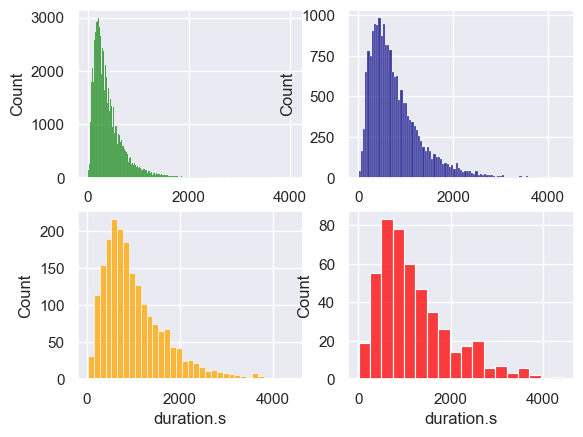

In [198]:
sns.set()
ghd, axes = plt.subplots(2, 2)
sns.histplot(data=energy1,x='duration.s',ax=axes[0,0],color='green')
sns.histplot(data=energy2,x='duration.s',ax=axes[0,1],color='navy')
sns.histplot(data=energy3,x='duration.s',ax=axes[1,0],color='orange')
sns.histplot(data=energy4,x='duration.s',ax=axes[1,1],color='red')
fighd=ghd.get_figure()
fighd.savefig("HistogramasDura.png")

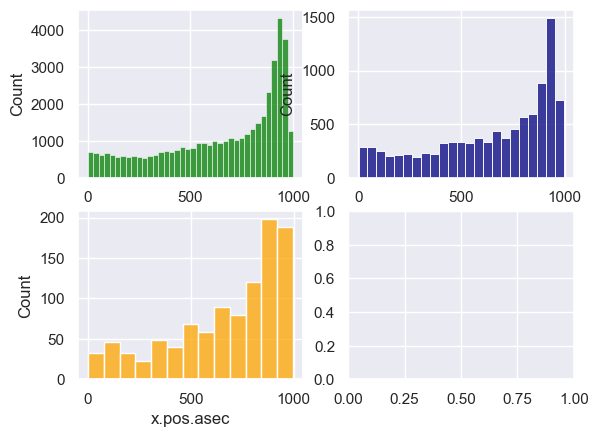

In [197]:
sns.set()
ghpox, axes = plt.subplots(2, 2)
sns.histplot(data=energypox1,x='x.pos.asec',ax=axes[0,0],color='green')
sns.histplot(data=energypox2,x='x.pos.asec',ax=axes[0,1],color='navy')
sns.histplot(data=energypox3,x='x.pos.asec',ax=axes[1,0],color='orange')
sns.histplot(data=energypox4,x='x.pos.asec',ax=axes[1,1],color='red')
fighpox=ghpox.get_figure()
fighpox.savefig("HistogramasPosX.png")

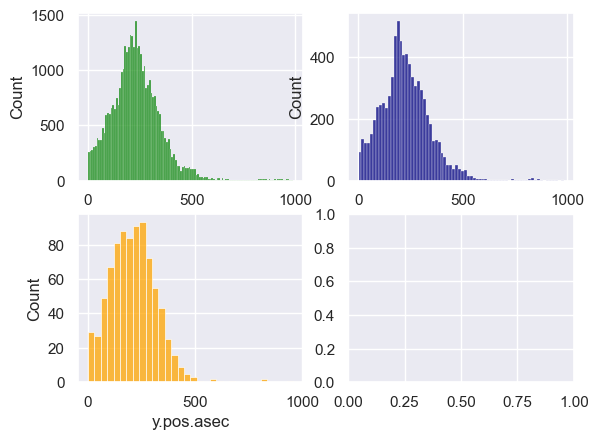

In [196]:
sns.set()
ghpoy, axes = plt.subplots(2, 2)
sns.histplot(data=energypoy1,x='y.pos.asec',ax=axes[0,0],color='green')
sns.histplot(data=energypoy2,x='y.pos.asec',ax=axes[0,1],color='navy')
sns.histplot(data=energypoy3,x='y.pos.asec',ax=axes[1,0],color='orange')
sns.histplot(data=energypoy4,x='y.pos.asec',ax=axes[1,1],color='red')
fighpoy=ghpoy.get_figure()
fighpoy.savefig("HistogramasPosY.png")

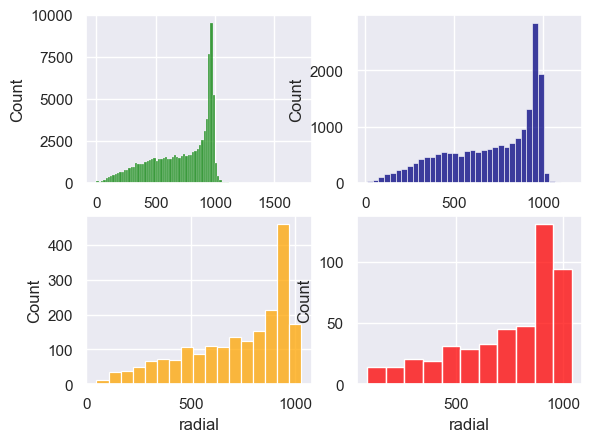

In [249]:
sns.set()
ghporad, axes = plt.subplots(2, 2)
sns.histplot(data=energy1,x='radial',ax=axes[0,0],color='green')
sns.histplot(data=energy2,x='radial',ax=axes[0,1],color='navy')
sns.histplot(data=energy3,x='radial',ax=axes[1,0],color='orange')
sns.histplot(data=energy4,x='radial',ax=axes[1,1],color='red')
fighrad=ghporad.get_figure()
fighrad.savefig("HistogramasRadial.png")